In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
from pickle import load
import os
import csv

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.recurrent import GRU, LSTM
from keras.regularizers import l1, activity_l1, l2, activity_l2,l1l2
from keras.wrappers.scikit_learn import KerasRegressor

import xgboost as xgb

from sklearn.metrics import accuracy_score, precision_score

import scipy.signal

/Users/Torben/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


Using Theano backend.
/Users/Torben/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def load_dat(root_dir,fname,cells=[1,5]):
    
    data_path = os.path.join(root_dir,dataset)
    with open(data_path, 'rb') as handle:
        data = load(handle) #, encoding='latin1'
        if not cells:
            cells = xrange(1,len(data)+1)
    data = [data[c - 1] for c in cells]
    
    return data

In [3]:
data_path = '/Users/Torben/Documents/cai-3_dataset/data/'
dataset = 'data.1.train.preprocessed.pck'  # AOD dataset
data = load_dat(data_path,dataset)

fnames = ['data.1.train.preprocessed.pck',
          'data.2.train.preprocessed.pck',
          'data.3.train.preprocessed.pck',
          'data.4.train.preprocessed.pck',
          #'data.5.train.preprocessed.pck' # save for validation
         ]

In [10]:
no_entries = len(data)
this_entry = data[1]
calcium = this_entry['calcium']
spikes = this_entry['spikes']
# somteimes spikes have 2 somehow
spikes[spikes>1]=1
srate = int(np.floor(this_entry['fps'])) # frames per second I think

#np.concatenate([data[0]['calcium'],data[1]['calcium']],1).shape
calcium_list = []
spikes_list = []
for f in fnames:
    print f
    data = load_dat(data_path,f)
    print [i['fps'] for i in data]
    temp_calcium = np.concatenate([i['calcium'] for i in data],1)
    calcium_list.append(temp_calcium)
    temp_spikes = np.concatenate([i['spikes'] for i in data],1)
    spikes_list.append(temp_spikes)

all_calcium = np.concatenate(calcium_list,1)    
all_calcium = all_calcium/np.std(all_calcium)
all_spikes = np.concatenate(spikes_list,1)    

data.1.train.preprocessed.pck
[100.00019488348508, 100.00018850041198]
data.2.train.preprocessed.pck
[100.00019488348508, 100.00018850041198]
data.3.train.preprocessed.pck
[100.00019488348508, 100.00018850041198]
data.4.train.preprocessed.pck
[100.00019488348508, 100.00018850041198]


In [11]:
print all_calcium.shape
print all_spikes.shape

(1, 575888)
(1, 575888)


In [12]:

def build_offset_features(raw_dat,n_offsets, forward=True, backward=True, verbose=False):
    '''
    Builds a feature matrix of imaging data n points away
    '''
    output_mat = np.zeros(raw_dat.shape);
    if forward:
        forward_mat = np.zeros((n_offsets,raw_dat.shape[1]))

        for n in xrange(1,n_offsets+1):
            if verbose:
                print 'Offsetting by ' + str(n)
            forward_mat[n-1,:] = np.roll(raw_dat,n)
            
        output_mat=np.vstack([output_mat,forward_mat])

    if backward:
        backward_mat = np.zeros((n_offsets,raw_dat.shape[1]))

        for n in xrange(1,n_offsets+1):
            if verbose:
                print 'Offsetting by -' + str(n)
            backward_mat[n-1,:] = np.roll(raw_dat,-1*n)
        
        output_mat=np.vstack([output_mat,backward_mat])

    return output_mat[1:,:]


def build_derivative_features(raw_dat):
    pre_diff=np.zeros(raw_dat.shape)
    post_diff=np.zeros(raw_dat.shape)
    diff2=np.zeros(raw_dat.shape)

    pre_diff[0,0:-1] = np.diff(raw_dat)
    post_diff[0,1:] = np.diff(raw_dat)

    diff2[0,1:-1] = np.diff(np.diff(raw_dat))

    return np.vstack([pre_diff,post_diff,diff2])


def build_smoothed_features(raw_dat,n_smooths=5):
    
    smooth_mat=np.zeros((n_smooths,raw_dat.shape[1]))
    this_medfilt=3
    for n in xrange(n_smooths):
        smooth_mat[n,:]=scipy.signal.medfilt(raw_dat[0,:],this_medfilt)
        this_medfilt+=2
    return smooth_mat


def gkern(kernlen=21, nsig=3):
    """Returns a 1D Gaussian kernel array."""

    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    
    return kern1d


In [13]:
import scipy.stats as st
t = gkern(kernlen=3,nsig=1)
print t.shape
print spikes.shape
convolved_spikes = np.convolve(spikes[0,:],t,mode='same')
print convolved_spikes.shape
#plt.plot(convolved_spikes[300:400])
print max(convolved_spikes)

(3,)
(1, 71986)
(71986,)
0.866385597462


(1, 71986)
(20, 575888)
(3, 575888)
(5, 575888)
(29, 575888)


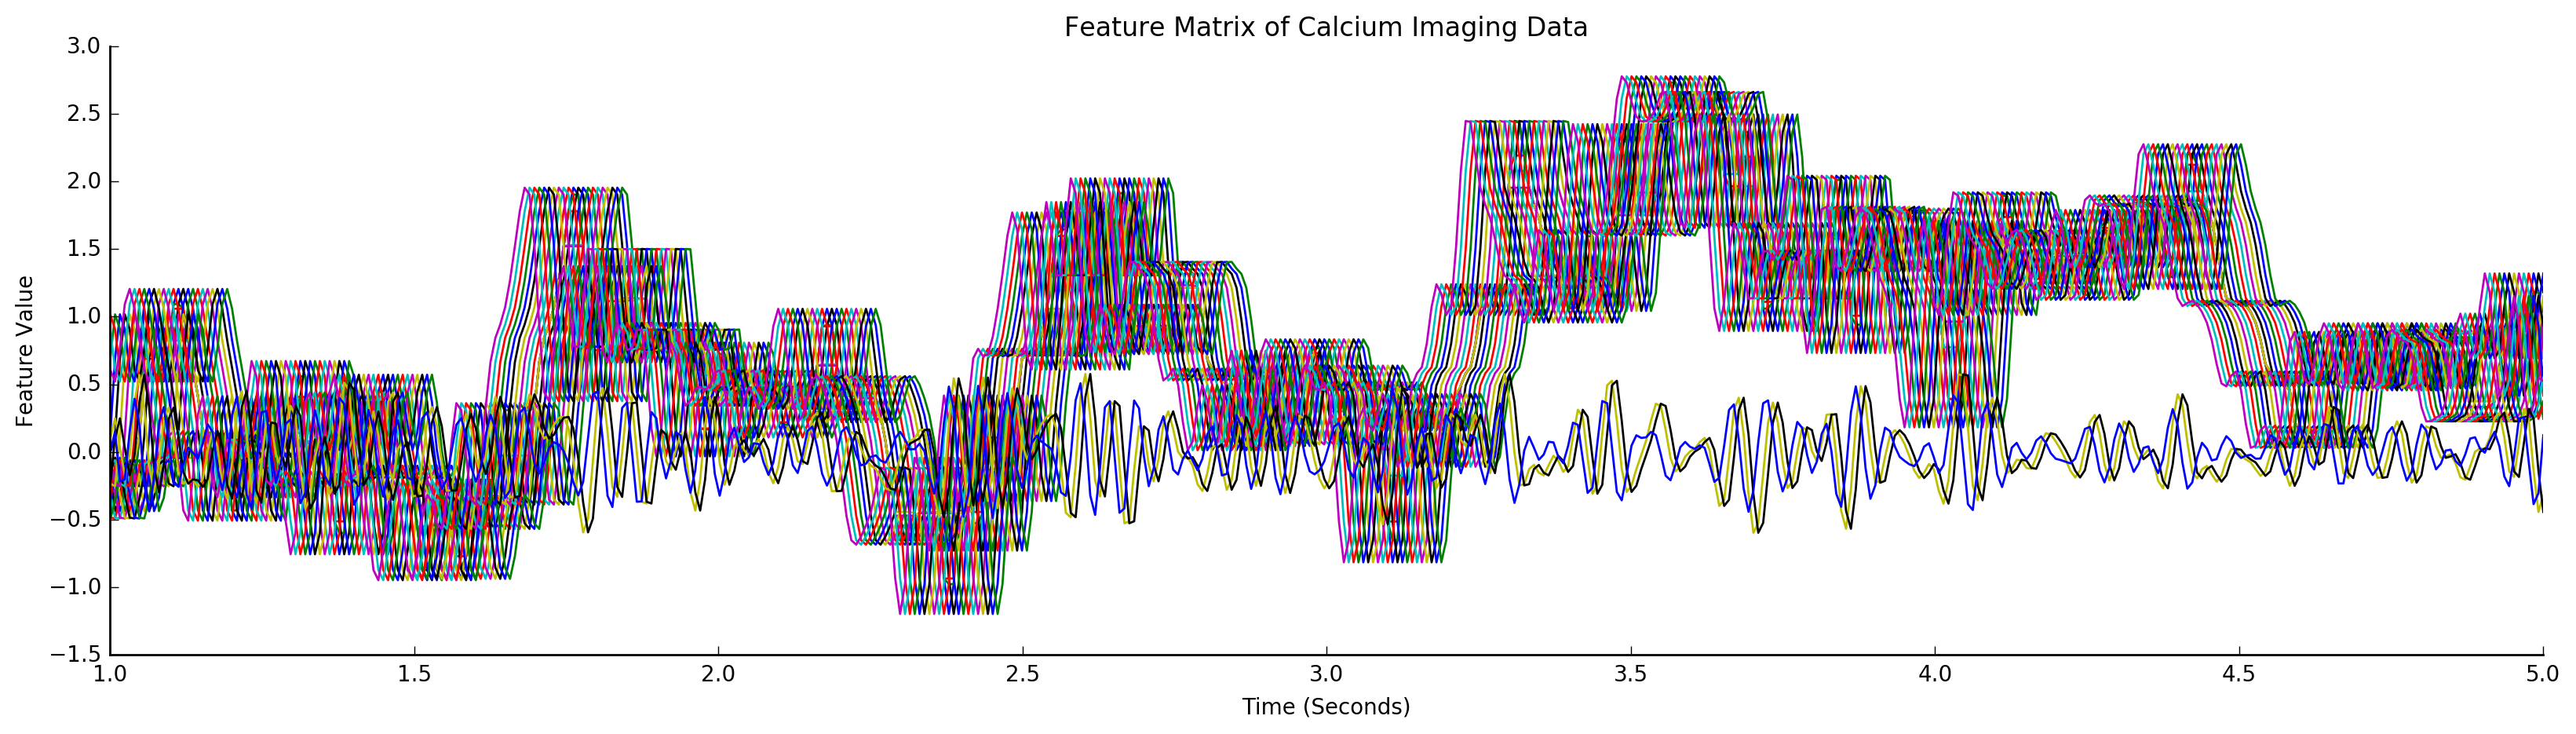

In [14]:
print calcium.shape
offset_mat = build_offset_features(all_calcium,10)
derivative_mat = build_derivative_features(all_calcium)
smooth_mat = build_smoothed_features(all_calcium,5)
calcium_feature_mat = np.vstack([all_calcium,smooth_mat,offset_mat,derivative_mat])
print offset_mat.shape
print derivative_mat.shape
print smooth_mat.shape
print calcium_feature_mat.shape

x_axis = np.linspace(1,5,500)
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(x_axis,calcium_feature_mat[:,:500].T);
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
ax1.set_title('Feature Matrix of Calcium Imaging Data')
ax1.set_ylabel('Feature Value')
ax1.set_xlabel('Time (Seconds)')
# box = ax1.get_position()
# ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# red_patch = mpatches.Patch(color='red', label='The red data')
# plt.legend(handles=[red_patch])


In [15]:

# toy_calcium = calcium_feature_mat[:,0:50000]
# toy_spikes = spikes[0,0:50000]
all_spikes[all_spikes>1]=1
X_train, X_test, y_train, y_test = train_test_split(calcium_feature_mat.T, all_spikes.T, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(460710, 29)
(115178, 29)
(460710, 1)
(115178, 1)


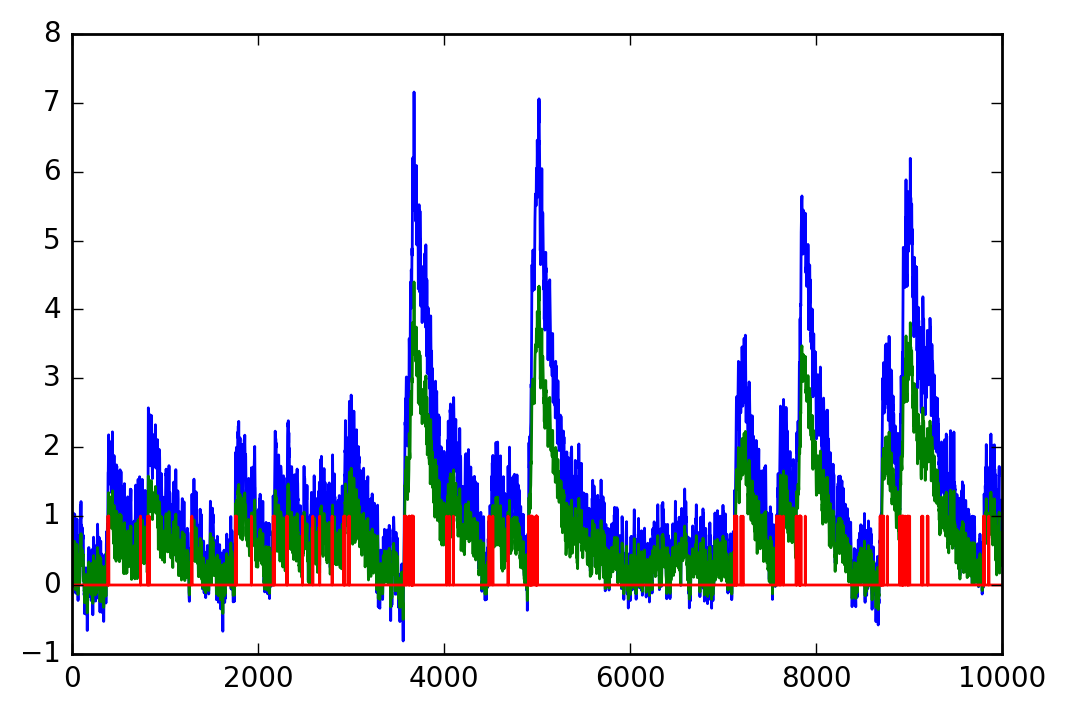

In [91]:
# norming works
c = calcium/np.std(calcium)
plot(c[0,:10000])
plot(calcium[0,:10000])
plot(spikes[0,:10000])

In [ ]:
# XGBoost hyperparameter optimization
outpath = '/Users/Torben/Code/calcium_spikes/output/'

params = {'objective': "binary:logistic",
'eval_metric': "error",
'eta': 1, #step size shrinkage. larger--> more conservative / less overfitting
'alpha':0.01, #l1 regularization
'lambda':0.01, #l2 regularizaion
'gamma':3, # default = 0, minimum loss reduction to further partitian on a leaf node. larger-->more conservative
#'max_depth': 5,
'seed': 16,
'silent': 1,
'missing': '-999.0',
#'colsample_bytree':.5 #new
}

num_round = 200
alphas = [0]
lambdas = [0,0.01,0.1]
gammas = [0,1,3,5]

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)
dtrain_y = xgb.DMatrix(X_train)

for a in xrange(len(alphas)):
    for l in xrange(len(lambdas)):
        for g in xrange(len(gammas)):

            params['alpha']=alphas[a]
            params['lambda']=lambdas[l]
            params['gamma']=gammas[g]
            
            model = xgb.train(params, dtrain, num_round)

            Yr = model.predict(dtrain_y)
            Yt = model.predict(dtest)

            Yr_rounded = np.array([round(i) for i in Yr]);
            Yt_rounded = np.array([round(i) for i in Yt]);
            train_accuracy = accuracy_score(y_train,Yr_rounded)
            test_accuracy = accuracy_score(y_test,Yt_rounded)
            train_precision = precision_score(y_train,Yr_rounded)
            test_precision = precision_score(y_test,Yt_rounded)

            
            print 'alpha: ' + str(a) + ' lambda: ' + str(l) + ' gamma: ' + str(g)
            print '='*10
            print 'training accuracy: ' + str(train_accuracy)
            print 'testing accuracy: ' + str(test_accuracy)
            print 'training precision: ' + str(train_precision)
            print 'testing precision: ' + str(test_precision)

            fname = 'alpha_' + str(a) + '_lambda_ ' + str(l) + '_gamma_' + str(g)+'.csv'
            with open(outpath+fname, 'wb') as csvfile:
                mywriter = csv.writer(csvfile, delimiter=',')
                mywriter.writerow(['training accuracy: ', str(train_accuracy)])
                mywriter.writerow(['testing accuracy: ', str(test_accuracy)])
                mywriter.writerow(['training precision: ', str(train_precision)])
                mywriter.writerow(['testing precision: ', str(test_precision)])

In [22]:
best_params = {'objective': "binary:logistic",
'eval_metric': "error",
'eta': 1, #step size shrinkage. larger--> more conservative / less overfitting
'alpha':0, #l1 regularization
'lambda':0.1, #l2 regularizaion
'gamma':1, # default = 0, minimum loss reduction to further partitian on a leaf node. larger-->more conservative
#'max_depth': 5,
'seed': 16,
'silent': 1,
'missing': '-999.0',
#'colsample_bytree':.5 #new
}

model = xgb.train(best_params, dtrain, num_round)

Yr = model.predict(dtrain_y)
Yt = model.predict(dtest)

Yr_rounded = np.array([round(i) for i in Yr]);
Yt_rounded = np.array([round(i) for i in Yt]);
train_accuracy = accuracy_score(y_train,Yr_rounded)
test_accuracy = accuracy_score(y_test,Yt_rounded)
train_precision = precision_score(y_train,Yr_rounded)
test_precision = precision_score(y_test,Yt_rounded)

In [78]:
thresh=0.5
Yt_ceil = Yt>thresh;
n_spikes_aggreed = len(np.intersect1d(np.where(y_test[:,0]), np.where(Yt_ceil)))

n_spikes_total = sum(y_test)
print 'Spikes Correctly Identified: ' + str(n_spikes_aggreed)
print 'Spikes Missed: ' + str(int(n_spikes_total - n_spikes_aggreed))
print 'Spikes Total: ' + str(n_spikes_total)
print 'Pct correct: ' + str(np.round((n_spikes_aggreed/float(n_spikes_total)*100),2))
print 'Pct missed: ' + str(np.round((1-(n_spikes_aggreed/float(n_spikes_total)))*100,2))

Spikes Correctly Identified: 1952
Spikes Missed: 372
Spikes Total: 2324
Pct correct: 83.99
Pct missed: 16.01


In [122]:
n_spikes_total = sum(y_test)
n_non_spikes = sum(y_test[:,0] == 0)
print n_non_spikes
thresh_vals = np.linspace(0,1,100)
true_positives = np.zeros(thresh_vals.shape)
false_positives = np.zeros(thresh_vals.shape)
true_negatives = np.zeros(thresh_vals.shape)
false_negatives = np.zeros(thresh_vals.shape)

for t in xrange(len(thresh_vals)):
    true_positives[t] = len(np.intersect1d(np.where(y_test[:,0]), np.where(Yt>thresh_vals[t])))/float(n_spikes_total)
    false_positives[t] = len(np.intersect1d(np.where(y_test[:,0]), np.where(Yt<=thresh_vals[t])))/float(n_spikes_total)
    true_negatives[t] = len(np.intersect1d(np.where(y_test[:,0] == 0), np.where(Yt<=thresh_vals[t])))/float(n_non_spikes)
    false_negatives[t] = len(np.intersect1d(np.where(y_test[:,0] == 0), np.where(Yt>thresh_vals[t])))/float(n_non_spikes)

112854


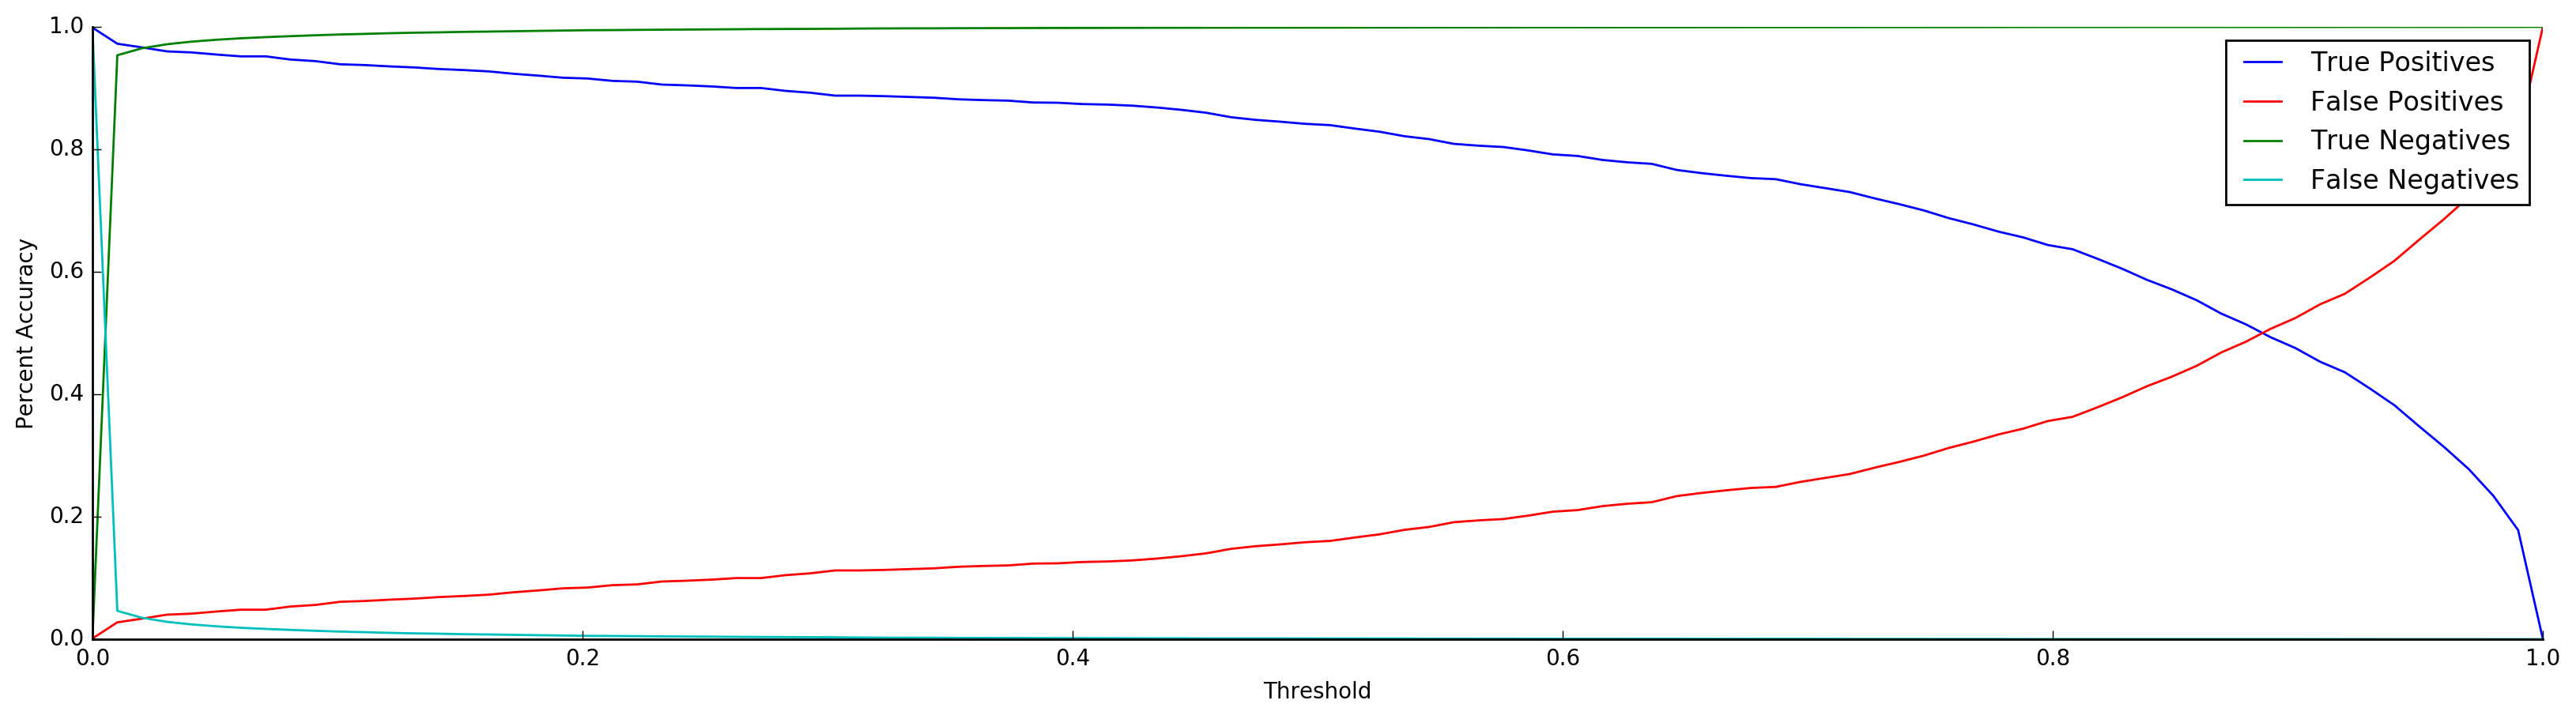

In [126]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,1,1)
#ax1.plot(true_positives,false_positives)
ax1.plot(thresh_vals,true_positives,'b',label='True Positives')
ax1.plot(thresh_vals,false_positives,'r',label='False Positives')
ax1.plot(thresh_vals,true_negatives,'g',label='True Negatives')
ax1.plot(thresh_vals,false_negatives,'c',label='False Negatives')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Percent Accuracy')
ax1.legend()


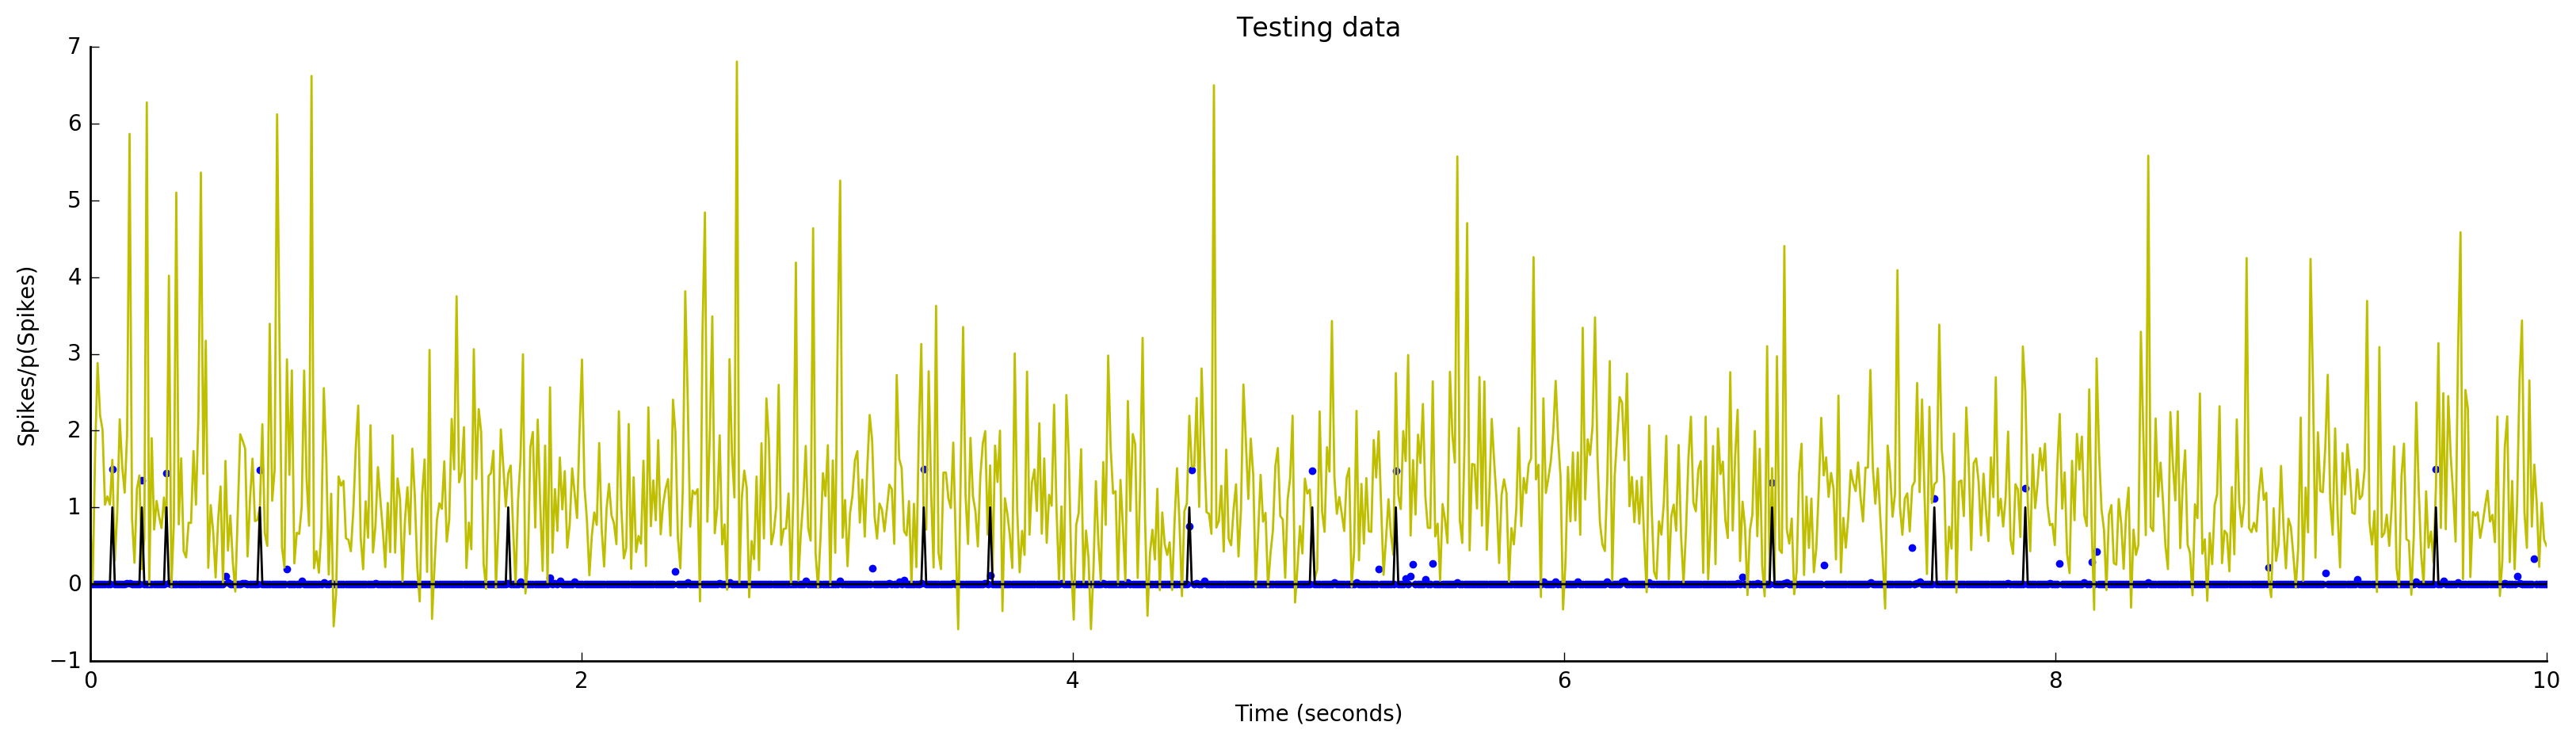

In [127]:
# demo figures
zoom_inds = [1000,2000]
x_axis = np.linspace(0,(zoom_inds[1]-zoom_inds[0])/srate,zoom_inds[1]-zoom_inds[0])
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(x_axis,Yt[zoom_inds[0]:zoom_inds[1]]*1.5,'b.') # *1.5 for visibility
ax1.plot(x_axis,X_test[zoom_inds[0]:zoom_inds[1],0],'y')
ax1.plot(x_axis,y_test[zoom_inds[0]:zoom_inds[1],0],'k')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Spikes/p(Spikes)')
ax1.set_title('Testing data')

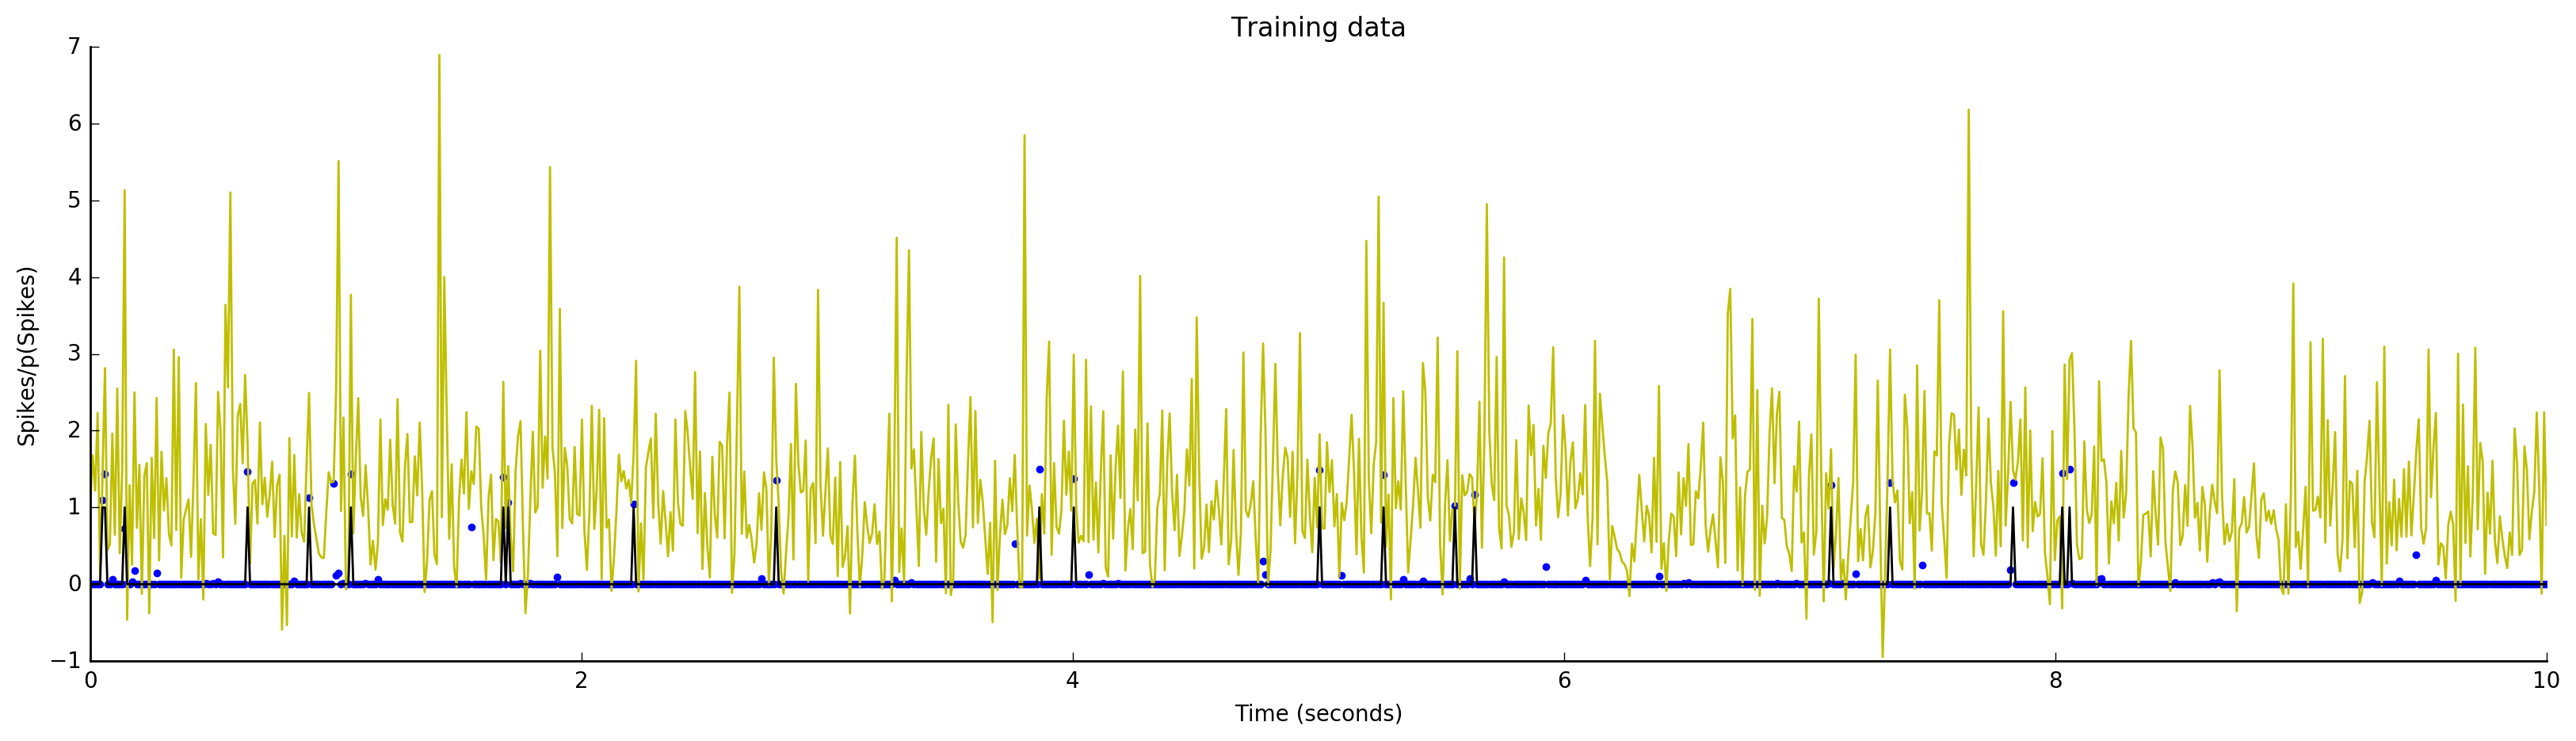

In [128]:
# demo figures
zoom_inds = [1000,2000]
x_axis = np.linspace(0,(zoom_inds[1]-zoom_inds[0])/srate,zoom_inds[1]-zoom_inds[0])
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(x_axis,Yr[zoom_inds[0]:zoom_inds[1]]*1.5,'b.') # *1.5 for visibility
ax1.plot(x_axis,X_train[zoom_inds[0]:zoom_inds[1],0],'y')
ax1.plot(x_axis,y_train[zoom_inds[0]:zoom_inds[1],0],'k')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Spikes/p(Spikes)')
ax1.set_title('Training data')